In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

#mpl.rcParams['figure.figsize'] = (10, 8)

# Use 3 decimal places in output display
pd.set_option("display.precision", 3)

sns.set(style="darkgrid")
%matplotlib inline

import matplotlib.pyplot as plt
#plt.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.figsize'] = (12, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.python.platform.build_info as build

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
from zipfile import ZipFile
import os

csv_path = "equipment1.csv"

#df = pd.read_csv(csv_path, parse_dates=['Time/Date'], header=0, index_col=['Time/Date'] )
df = pd.read_csv(csv_path)

df.head()

,Time/Date,Payload SMH,Equipment Number,Payload(Tons),Travel Empty Time (hh:mm:ss),Travel Empty Distance(Mi),Stopped Empty Time (hh:mm:ss),Load Time (hh:mm:ss),Stopped Loaded Time (hh:mm:ss),Loaded Travel Time (hh:mm:ss),Loaded Travel Distance(Mi),Cycle Time (hh:mm:ss),Cycle Distance(Mi),Loader Passes,Fuel Used (Gal)
0,01/01/2020 20:53:02,22566,SPD00397,186.329,00:09:32,2.1,00:06:27,00:03:09,00:01:08,00:10:50,1.9,00:31:06,4.0,5,30.750
1,01/01/2020 21:24:09,22566,SPD00397,205.072,00:07:21,1.9,00:01:58,00:02:31,00:02:29,00:11:04,1.8,00:25:23,3.7,5,18.000
2,01/01/2020 21:49:32,22567,SPD00397,196.362,00:06:48,1.9,00:00:08,00:03:32,00:02:36,00:11:54,1.9,00:24:58,3.8,6,17.625
3,01/01/2020 22:14:30,22567,SPD00397,210.474,00:07:36,1.9,00:03:46,00:04:02,00:00:57,00:11:24,1.9,00:27:45,3.8,7,18.125
4,01/01/2020 22:42:15,22568,SPD00397,208.159,00:07:03,1.9,00:01:12,00:04:23,00:01:15,00:11:09,1.9,00:25:02,3.8,7,17.750


In [5]:
df['year'] = pd.DatetimeIndex(df['Time/Date']).year
df['month'] = pd.DatetimeIndex(df['Time/Date']).month
df['day'] = pd.DatetimeIndex(df['Time/Date']).day

import calendar
df['month'] = df['month'].apply(lambda x: calendar.month_abbr[x])

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

df.month = pd.Categorical(df.month, months)

df.head()

,Time/Date,Payload SMH,Equipment Number,Payload(Tons),Travel Empty Time (hh:mm:ss),Travel Empty Distance(Mi),Stopped Empty Time (hh:mm:ss),Load Time (hh:mm:ss),Stopped Loaded Time (hh:mm:ss),Loaded Travel Time (hh:mm:ss),Loaded Travel Distance(Mi),Cycle Time (hh:mm:ss),Cycle Distance(Mi),Loader Passes,Fuel Used (Gal),year,month,day
0,01/01/2020 20:53:02,22566,SPD00397,186.329,00:09:32,2.1,00:06:27,00:03:09,00:01:08,00:10:50,1.9,00:31:06,4.0,5,30.750,2020,Jan,1
1,01/01/2020 21:24:09,22566,SPD00397,205.072,00:07:21,1.9,00:01:58,00:02:31,00:02:29,00:11:04,1.8,00:25:23,3.7,5,18.000,2020,Jan,1
2,01/01/2020 21:49:32,22567,SPD00397,196.362,00:06:48,1.9,00:00:08,00:03:32,00:02:36,00:11:54,1.9,00:24:58,3.8,6,17.625,2020,Jan,1
3,01/01/2020 22:14:30,22567,SPD00397,210.474,00:07:36,1.9,00:03:46,00:04:02,00:00:57,00:11:24,1.9,00:27:45,3.8,7,18.125,2020,Jan,1
4,01/01/2020 22:42:15,22568,SPD00397,208.159,00:07:03,1.9,00:01:12,00:04:23,00:01:15,00:11:09,1.9,00:25:02,3.8,7,17.750,2020,Jan,1


In [6]:
df['Travel Empty Time (hh:mm:ss)'] = pd.to_timedelta(df['Travel Empty Time (hh:mm:ss)'], errors='coerce') / pd.offsets.Minute(1)
df['Stopped Empty Time (hh:mm:ss)'] = pd.to_timedelta(df['Stopped Empty Time (hh:mm:ss)'], errors='coerce') / pd.offsets.Minute(1)
df['Load Time (hh:mm:ss)'] = pd.to_timedelta(df['Load Time (hh:mm:ss)'], errors='coerce') / pd.offsets.Minute(1)
df['Stopped Loaded Time (hh:mm:ss)'] = pd.to_timedelta(df['Stopped Loaded Time (hh:mm:ss)'], errors='coerce') / pd.offsets.Minute(1)
df['Loaded Travel Time (hh:mm:ss)'] =pd.to_timedelta(df['Loaded Travel Time (hh:mm:ss)'], errors='coerce') / pd.offsets.Minute(1)
df['Cycle Time (hh:mm:ss)'] = pd.to_timedelta(df['Cycle Time (hh:mm:ss)'], errors='coerce') / pd.offsets.Minute(1)
df.head()

,Time/Date,Payload SMH,Equipment Number,Payload(Tons),Travel Empty Time (hh:mm:ss),Travel Empty Distance(Mi),Stopped Empty Time (hh:mm:ss),Load Time (hh:mm:ss),Stopped Loaded Time (hh:mm:ss),Loaded Travel Time (hh:mm:ss),Loaded Travel Distance(Mi),Cycle Time (hh:mm:ss),Cycle Distance(Mi),Loader Passes,Fuel Used (Gal),year,month,day
0,01/01/2020 20:53:02,22566,SPD00397,186.329,9.533,2.1,6.450,3.150,1.133,10.833,1.9,31.100,4.0,5,30.750,2020,Jan,1
1,01/01/2020 21:24:09,22566,SPD00397,205.072,7.350,1.9,1.967,2.517,2.483,11.067,1.8,25.383,3.7,5,18.000,2020,Jan,1
2,01/01/2020 21:49:32,22567,SPD00397,196.362,6.800,1.9,0.133,3.533,2.600,11.900,1.9,24.967,3.8,6,17.625,2020,Jan,1
3,01/01/2020 22:14:30,22567,SPD00397,210.474,7.600,1.9,3.767,4.033,0.950,11.400,1.9,27.750,3.8,7,18.125,2020,Jan,1
4,01/01/2020 22:42:15,22568,SPD00397,208.159,7.050,1.9,1.200,4.383,1.250,11.150,1.9,25.033,3.8,7,17.750,2020,Jan,1


array([[<AxesSubplot:title={'center':'Payload SMH'}>,
        <AxesSubplot:title={'center':'Payload(Tons)'}>,
        <AxesSubplot:title={'center':'Travel Empty Time (hh:mm:ss)'}>,
        <AxesSubplot:title={'center':'Travel Empty Distance(Mi)'}>],
       [<AxesSubplot:title={'center':'Stopped Empty Time (hh:mm:ss)'}>,
        <AxesSubplot:title={'center':'Load Time (hh:mm:ss)'}>,
        <AxesSubplot:title={'center':'Stopped Loaded Time (hh:mm:ss)'}>,
        <AxesSubplot:title={'center':'Loaded Travel Time (hh:mm:ss)'}>],
       [<AxesSubplot:title={'center':'Loaded Travel Distance(Mi)'}>,
        <AxesSubplot:title={'center':'Cycle Time (hh:mm:ss)'}>,
        <AxesSubplot:title={'center':'Cycle Distance(Mi)'}>,
        <AxesSubplot:title={'center':'Loader Passes'}>],
       [<AxesSubplot:title={'center':'Fuel Used (Gal)'}>,
        <AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'day'}>, <AxesSubplot:>]],
      dtype=object)

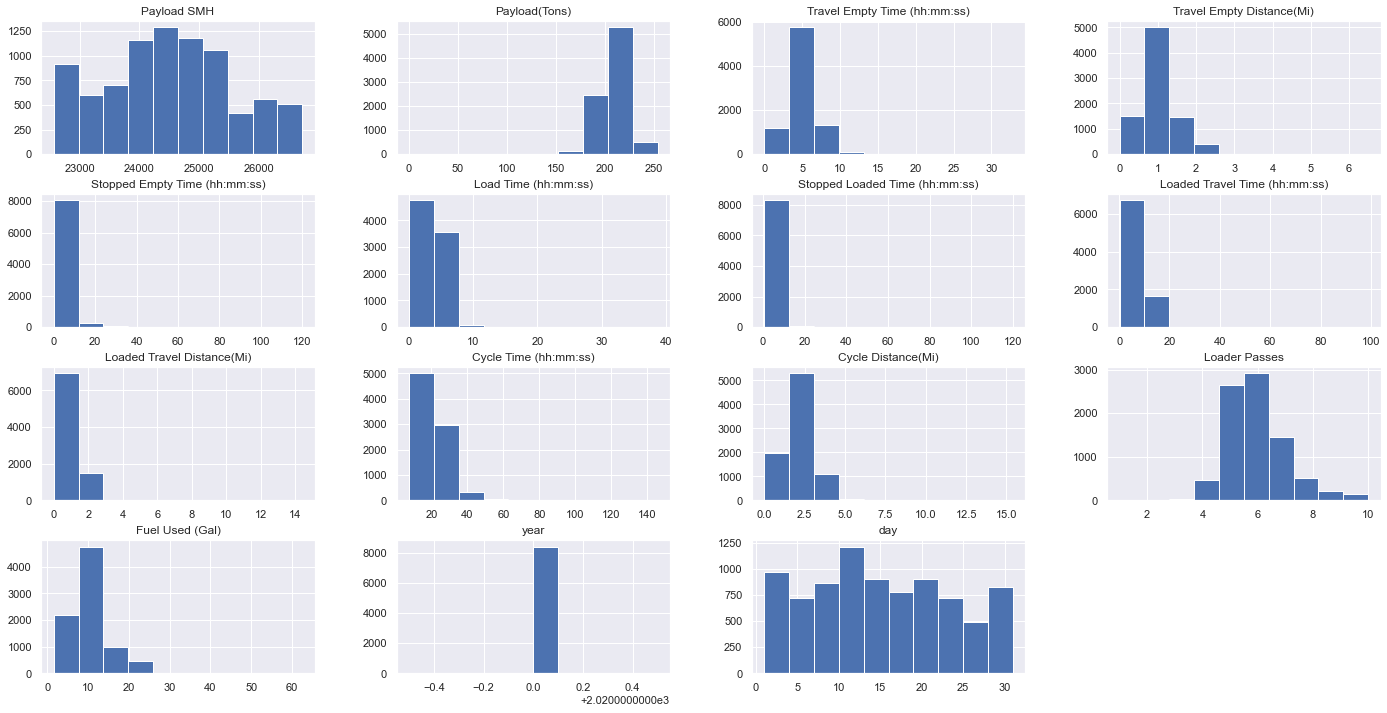

In [7]:
df.hist(figsize=(24,12), log = False)

# Production (Tons)

In [8]:
df.groupby(['Equipment Number','month'])["Payload(Tons)"].describe()

count     mean     std      min      25%      50%  \
Equipment Number month                                                       
SPD00397         Jan     931.0  213.133  15.153    2.646  205.237  213.782   
                 Feb     556.0  211.651  21.321    8.049  205.926  214.664   
                 Mar     558.0  211.165  17.232   61.411  205.320  212.404   
                 Apr     842.0  212.253  15.168   12.789  204.079  213.561   
                 May    1067.0  208.730  13.463    2.867  201.213  209.372   
                 Jun    1091.0  206.046  16.021    0.110  198.015  207.387   
                 Jul     666.0  202.783  16.031    0.441  193.826  204.355   
                 Aug    1003.0  205.547  12.897    4.410  197.740  206.064   
                 Sep     505.0  204.353  15.945    0.221  197.133  204.851   
                 Oct     669.0  201.290  13.681  146.858  192.503  202.756   
                 Nov      48.0  209.420  11.027  189.967  201.185  209.647   
                 Dec     462.0  213.557  11.354  173.649  206.284  213.341   

                            75%      max  
Equipment Number month                    
SPD00397         Jan    221.775  246.307  
                 Feb    221.610  243.330  
                 Mar    219.956  253.583  
                 Apr    221.610  242.999  
                 May    217.089  247.409  
                 Jun    215.822  244.653  
                 Jul    213.010  233.848  
                 Aug    213.561  241.014  
                 Sep    212.679  244.873  
                 Oct    211.025  239.140  
                 Nov    217.090  232.084  
                 Dec    221.830  240.684

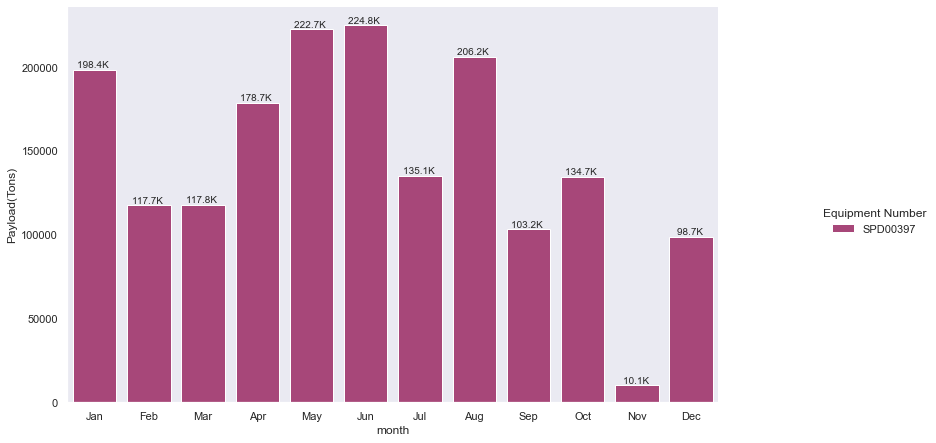

In [9]:
#sns.barplot(x="month", y="Payload(Tons)", data=df, estimator=sum)
g = sns.catplot(x="month", y="Payload(Tons)", data=df, estimator=sum, kind='bar', hue='Equipment Number', legend=True, palette="magma", ci=None)
g.fig.set_size_inches(15, 8)
g.fig.subplots_adjust(top=0.81, right=0.8)

# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)

# iterate through the axes containers
for c in ax.containers:
    labels = [f'{(v.get_height() / 1000):.1f}K ' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

In [47]:
import plotly.express as px
fig = px.bar(df, x="month", y="Payload(Tons)", height=400)
fig.show()

In [37]:
import plotly.express as px

fig = px.bar(df, x="month", y="Payload(Tons)",
             hover_data=['Equipment Number'], color='lifeExp',
             labels={'pop':'population of Canada'}, height=400)
fig.show()

ValueError: Value of 'color' is not the name of a column in 'data_frame'. Expected one of ['Time/Date', 'Payload SMH', 'Equipment Number', 'Payload(Tons)', 'Travel Empty Time (hh:mm:ss)', 'Travel Empty Distance(Mi)', 'Stopped Empty Time (hh:mm:ss)', 'Load Time (hh:mm:ss)', 'Stopped Loaded Time (hh:mm:ss)', 'Loaded Travel Time (hh:mm:ss)', 'Loaded Travel Distance(Mi)', 'Cycle Time (hh:mm:ss)', 'Cycle Distance(Mi)', 'Loader Passes', 'Fuel Used (Gal)', 'year', 'month', 'day', 'Cycles per hour (Cycle/hr)', 'Fuel consumed per hour (Gal/hr)', 'Tons per hour (Tons/hr)', 'Total hours per year (hr/year)'] but received: lifeExp

In [10]:
df.groupby(['Equipment Number','month'])["Payload(Tons)"].sum()

Equipment Number  month
SPD00397          Jan      198426.790
                  Feb      117677.837
                  Mar      117829.980
                  Apr      178716.861
                  May      222714.664
                  Jun      224796.463
                  Jul      135053.689
                  Aug      206163.498
                  Sep      103198.451
                  Oct      134662.857
                  Nov       10052.152
                  Dec       98663.286
Name: Payload(Tons), dtype: float64

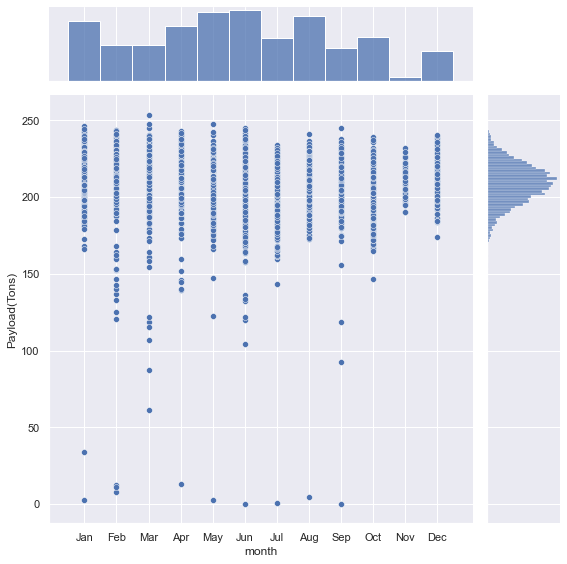

In [11]:
sns.set(style="darkgrid")
fig=sns.jointplot(x="month", y="Payload(Tons)", data=df, height = 8)

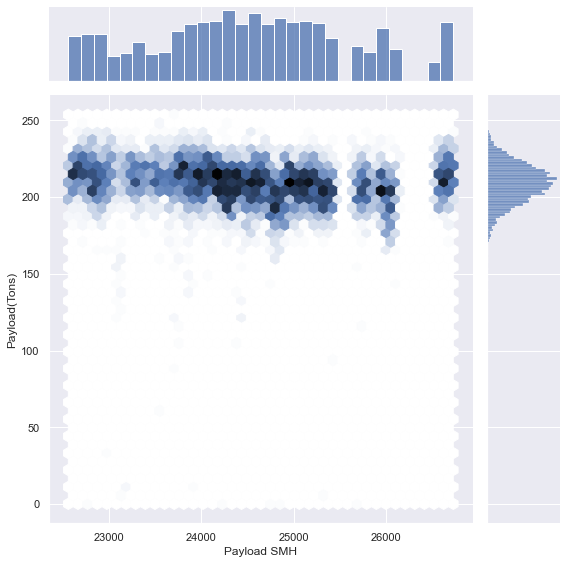

In [12]:
sns.set(style="darkgrid")
sns.jointplot(x="Payload SMH", y="Payload(Tons)", data=df, kind="hex", height = 8)

<AxesSubplot:xlabel='Payload SMH', ylabel='Payload(Tons)'>

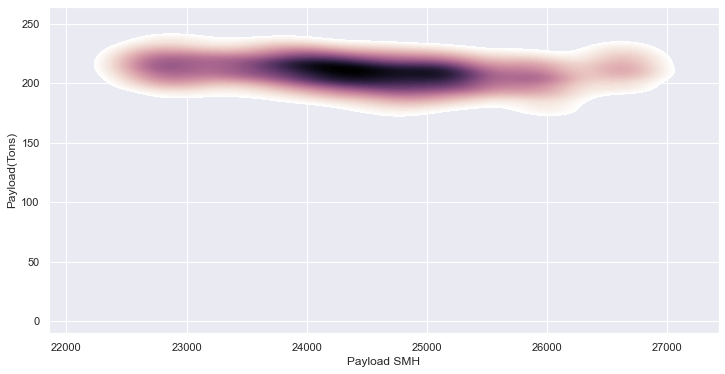

In [13]:
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=False)
sns.kdeplot(x="Payload SMH", y="Payload(Tons)", data=df, cmap=cmap, n_levels=100, shade=True)

In [14]:
df.groupby(['Equipment Number','month'])["Fuel Used (Gal)"].describe()

count    mean    std    min     25%     50%     75%  \
Equipment Number month                                                         
SPD00397         Jan     931.0  14.045  6.010  1.625   7.375  17.375  18.750   
                 Feb     556.0  16.856  5.774  3.375  16.750  19.000  20.375   
                 Mar     558.0  13.072  7.143  4.625   7.000   9.188  19.344   
                 Apr     842.0   8.175  3.366  2.875   6.750   7.500   8.250   
                 May    1067.0   9.088  4.434  3.125   7.250   7.875   8.875   
                 Jun    1091.0   9.223  2.933  1.750   8.375   8.750   9.250   
                 Jul     666.0  10.086  2.438  7.625   9.250   9.750  10.500   
                 Aug    1003.0  10.430  3.121  3.500   9.375  10.625  11.375   
                 Sep     505.0   9.347  2.670  2.000   8.000   9.000   9.875   
                 Oct     669.0   8.549  1.478  5.500   7.750   8.375   9.125   
                 Nov      48.0   7.872  1.182  5.875   7.125   7.625   8.406   
                 Dec     462.0   8.067  2.023  3.625   7.250   7.750   8.594   

                           max  
Equipment Number month          
SPD00397         Jan    40.625  
                 Feb    37.750  
                 Mar    54.125  
                 Apr    41.750  
                 May    33.000  
                 Jun    40.875  
                 Jul    62.500  
                 Aug    51.625  
                 Sep    38.375  
                 Oct    21.375  
                 Nov    14.125  
                 Dec    34.125

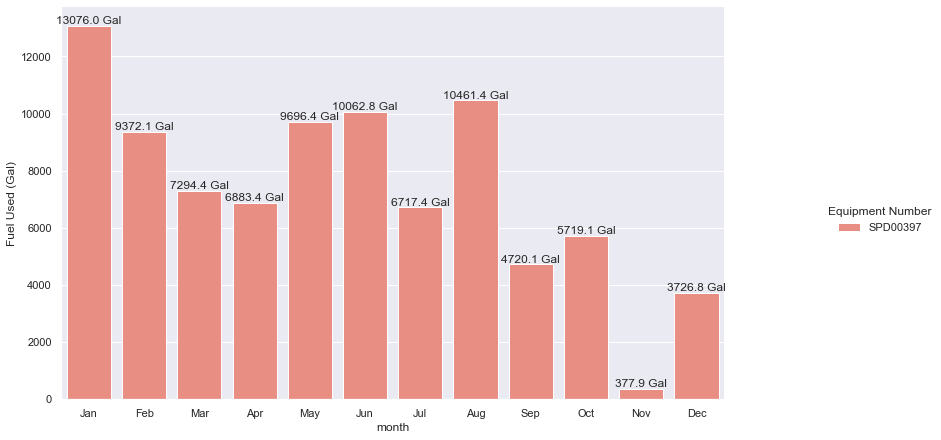

In [15]:
#sns.barplot(x="month", y="Payload(Tons)", data=df, estimator=sum)
g = sns.catplot(x="month", y="Fuel Used (Gal)", data=df, estimator=sum, kind='bar', hue='Equipment Number', legend=True, palette="dark:salmon_r", ci=None)
g.fig.set_size_inches(15, 8)
g.fig.subplots_adjust(top=0.81, right=0.8)

# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)

# iterate through the axes containers
for c in ax.containers:
    labels = [f'{(v.get_height() / 1):.1f} Gal' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

In [16]:
df.groupby(['Equipment Number','month'])["Fuel Used (Gal)"].sum()

Equipment Number  month
SPD00397          Jan      13076.000
                  Feb       9372.125
                  Mar       7294.375
                  Apr       6883.375
                  May       9696.375
                  Jun      10062.750
                  Jul       6717.375
                  Aug      10461.375
                  Sep       4720.125
                  Oct       5719.125
                  Nov        377.875
                  Dec       3726.750
Name: Fuel Used (Gal), dtype: float64

# Efectividad operational 

In [17]:
df1 = df[['month','Equipment Number','Payload(Tons)','Travel Empty Time (hh:mm:ss)', 'Stopped Empty Time (hh:mm:ss)', 'Load Time (hh:mm:ss)', 'Stopped Loaded Time (hh:mm:ss)', 'Loaded Travel Time (hh:mm:ss)', 'Cycle Time (hh:mm:ss)','Fuel Used (Gal)','Loader Passes']]
df1.head()

#fleet.get_group("SPD00536")
#equipment = fleet.get_group("SPD00397")

,month,Equipment Number,Payload(Tons),Travel Empty Time (hh:mm:ss),Stopped Empty Time (hh:mm:ss),Load Time (hh:mm:ss),Stopped Loaded Time (hh:mm:ss),Loaded Travel Time (hh:mm:ss),Cycle Time (hh:mm:ss),Fuel Used (Gal),Loader Passes
0,Jan,SPD00397,186.329,9.533,6.450,3.150,1.133,10.833,31.100,30.750,5
1,Jan,SPD00397,205.072,7.350,1.967,2.517,2.483,11.067,25.383,18.000,5
2,Jan,SPD00397,196.362,6.800,0.133,3.533,2.600,11.900,24.967,17.625,6
3,Jan,SPD00397,210.474,7.600,3.767,4.033,0.950,11.400,27.750,18.125,7
4,Jan,SPD00397,208.159,7.050,1.200,4.383,1.250,11.150,25.033,17.750,7


In [18]:
df1.describe()

,Payload(Tons),Travel Empty Time (hh:mm:ss),Stopped Empty Time (hh:mm:ss),Load Time (hh:mm:ss),Stopped Loaded Time (hh:mm:ss),Loaded Travel Time (hh:mm:ss),Cycle Time (hh:mm:ss),Fuel Used (Gal),Loader Passes
count,8398.000,8398.000,8398.000,8398.000,8398.000,8398.000,8398.000,8398.000,8398.000
mean,208.140,4.940,2.986,3.972,1.989,7.869,21.757,10.492,5.983
std,15.762,1.988,5.651,1.296,3.218,2.912,8.541,4.804,1.237
min,0.110,0.000,0.000,0.083,0.667,0.217,7.517,1.625,1.000
25%,200.331,3.783,0.300,3.133,0.983,6.017,16.717,7.625,5.000
50%,209.261,4.667,1.333,3.750,1.150,7.233,19.867,8.875,6.000
75%,217.530,5.867,3.617,4.533,1.717,9.167,24.750,11.000,7.000
max,253.583,32.817,120.000,38.650,120.000,98.900,145.667,62.500,10.000


# Increased haul & return speed = Increased cycles

In [19]:
#### 789D Nominal Payload 181 tonnes 200 tons Capacity 

#### 789D truck
payload = 208.140 #ton payload average 
cycle_time = 21.757 #cycle time average 

# 60 minutes / cycle_time
cycles = 60 / cycle_time 
print('Cycles per hour:', cycles , 'cycles/hr')

Cycles per hour: 2.757733143356161 cycles/hr


In [20]:
# 21.7 min cycle = 2.7577 cycles/hr 15 min cycle = 4 cycles /hr

#4 cycles/hr x 200 tons    =  800 tons/hr
ideal_production = 4 * payload

print('Ideal production:', ideal_production, 'tons/hr')

Ideal production: 832.56 tons/hr


In [21]:
real_production = cycles * payload 
#3.15 cycles/hr x 210 tons =  661 tons/hr
#125 tons
print('Real production:', real_production, 'tons/hr')

Real production: 573.9945764581513 tons/hr


In [22]:
total_loss = ideal_production - real_production 
print('loss production per hour:', total_loss , 'tons')

loss production per hour: 258.56542354184865 tons


In [23]:
# 258.56 tons x .75 eff = 193.92 tons
tons_per_month = total_loss * 0.75
print('loss tons per hour:', tons_per_month, 'tons')

loss tons per hour: 193.92406765638648 tons


In [24]:
# 100 tons x 10 trucks = 1000 tons/hr
total_loss_fleet = tons_per_month * 10
print('Total loss per fleet',total_loss_fleet, 'tons/hr')

Total loss per fleet 1939.2406765638648 tons/hr


In [25]:
# 1939.24 tons/hr x 6000 hrs = 11,635,444.05 tons/annual
tons_annual_loss = total_loss_fleet * 6000
print('Total anual loss fleet:',tons_annual_loss, 'tons/annual')

Total anual loss fleet: 11635444.05938319 tons/annual


In [26]:
efectividad = df1.groupby(['Equipment Number','month'])['Payload(Tons)','Travel Empty Time (hh:mm:ss)', 'Stopped Empty Time (hh:mm:ss)', 'Load Time (hh:mm:ss)', 'Stopped Loaded Time (hh:mm:ss)', 'Loaded Travel Time (hh:mm:ss)', 'Cycle Time (hh:mm:ss)', 'Fuel Used (Gal)'].sum() / 60
efectividad = pd.DataFrame(efectividad)

C:\Users\ricar\AppData\Local\Temp/ipykernel_46544/1022508705.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  efectividad = df1.groupby(['Equipment Number','month'])['Payload(Tons)','Travel Empty Time (hh:mm:ss)', 'Stopped Empty Time (hh:mm:ss)', 'Load Time (hh:mm:ss)', 'Stopped Loaded Time (hh:mm:ss)', 'Loaded Travel Time (hh:mm:ss)', 'Cycle Time (hh:mm:ss)', 'Fuel Used (Gal)'].sum() / 60


<AxesSubplot:xlabel='Equipment Number,month'>

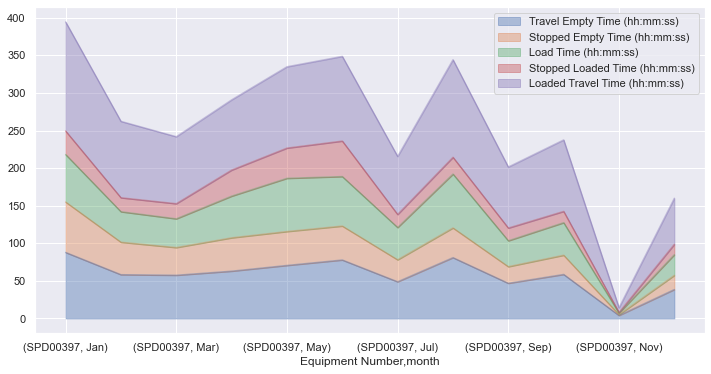

In [27]:
efectividad.plot.area(y=['Travel Empty Time (hh:mm:ss)', 'Stopped Empty Time (hh:mm:ss)', 'Load Time (hh:mm:ss)', 'Stopped Loaded Time (hh:mm:ss)', 'Loaded Travel Time (hh:mm:ss)'],alpha=0.4, figsize=(12, 6))

In [28]:
efectividad.head(12)

Payload(Tons)  Travel Empty Time (hh:mm:ss)  \
Equipment Number month                                                
SPD00397         Jan         3307.113                        87.773   
                 Feb         1961.297                        58.178   
                 Mar         1963.833                        57.413   
                 Apr         2978.614                        62.835   
                 May         3711.911                        70.468   
                 Jun         3746.608                        77.714   
                 Jul         2250.895                        48.720   
                 Aug         3436.058                        80.846   
                 Sep         1719.974                        46.701   
                 Oct         2244.381                        58.502   
                 Nov          167.536                         3.881   
                 Dec         1644.388                        38.409   

                        Stopped Empty Time (hh:mm:ss)  Load Time (hh:mm:ss)  \
Equipment Number month                                                        
SPD00397         Jan                           67.074                63.206   
                 Feb                           43.178                40.557   
                 Mar                           36.807                38.245   
                 Apr                           44.368                55.431   
                 May                           45.106                70.782   
                 Jun                           45.151                65.827   
                 Jul                           29.227                42.965   
                 Aug                           39.500                71.690   
                 Sep                           22.115                34.444   
                 Oct                           25.552                43.300   
                 Nov                            1.063                 2.066   
                 Dec                           18.827                27.499   

                        Stopped Loaded Time (hh:mm:ss)  \
Equipment Number month                                   
SPD00397         Jan                            31.270   
                 Feb                            18.614   
                 Mar                            20.125   
                 Apr                            34.651   
                 May                            40.218   
                 Jun                            47.265   
                 Jul                            17.355   
                 Aug                            22.323   
                 Sep                            16.925   
                 Oct                            15.001   
                 Nov                             0.865   
                 Dec                            13.796   

                        Loaded Travel Time (hh:mm:ss)  Cycle Time (hh:mm:ss)  \
Equipment Number month                                                         
SPD00397         Jan                          145.182                394.504   
                 Feb                          101.648                262.175   
                 Mar                           89.143                241.734   
                 Apr                           93.486                290.772   
                 May                          108.223                334.797   
                 Jun                          112.667                348.624   
                 Jul                           77.233                215.501   
                 Aug                          129.836                344.193   
                 Sep                           81.239                201.424   
                 Oct                           95.137                237.491   
                 Nov                            6.304                 14.179   
                 Dec                           61.348                

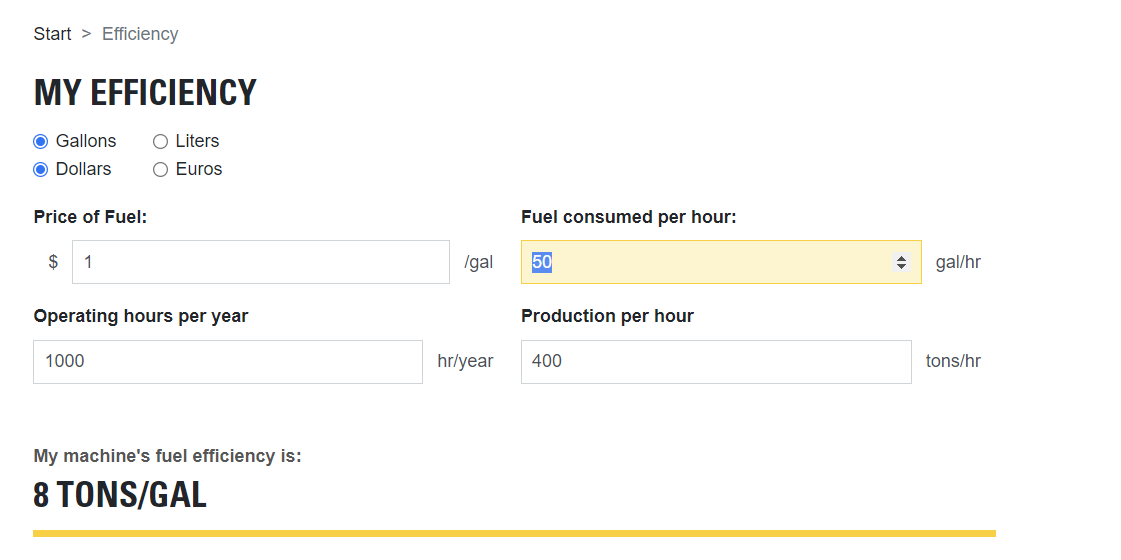

In [29]:
#df['operation (hr)'] = df['Cycle Time (hh:mm:ss)'].groupby(df['Payload SMH']).transform('sum') / 60


#cycles per hour
df['Cycles per hour (Cycle/hr)'] = 60 / df['Cycle Time (hh:mm:ss)']

# Fuel consumed per hour 
df['Fuel consumed per hour (Gal/hr)'] = df['Fuel Used (Gal)'].groupby(df['Payload SMH']).transform('sum')

# tons per hour 
df['Tons per hour (Tons/hr)'] = df['Payload(Tons)'].groupby(df['Payload SMH']).transform('sum')
df.head()

,Time/Date,Payload SMH,Equipment Number,Payload(Tons),Travel Empty Time (hh:mm:ss),Travel Empty Distance(Mi),Stopped Empty Time (hh:mm:ss),Load Time (hh:mm:ss),Stopped Loaded Time (hh:mm:ss),Loaded Travel Time (hh:mm:ss),...,Cycle Time (hh:mm:ss),Cycle Distance(Mi),Loader Passes,Fuel Used (Gal),year,month,day,Cycles per hour (Cycle/hr),Fuel consumed per hour (Gal/hr),Tons per hour (Tons/hr)
0,01/01/2020 20:53:02,22566,SPD00397,186.329,9.533,2.1,6.450,3.150,1.133,10.833,...,31.100,4.0,5,30.750,2020,Jan,1,1.929,48.750,391.401
1,01/01/2020 21:24:09,22566,SPD00397,205.072,7.350,1.9,1.967,2.517,2.483,11.067,...,25.383,3.7,5,18.000,2020,Jan,1,2.364,48.750,391.401
2,01/01/2020 21:49:32,22567,SPD00397,196.362,6.800,1.9,0.133,3.533,2.600,11.900,...,24.967,3.8,6,17.625,2020,Jan,1,2.403,35.750,406.836
3,01/01/2020 22:14:30,22567,SPD00397,210.474,7.600,1.9,3.767,4.033,0.950,11.400,...,27.750,3.8,7,18.125,2020,Jan,1,2.162,35.750,406.836
4,01/01/2020 22:42:15,22568,SPD00397,208.159,7.050,1.9,1.200,4.383,1.250,11.150,...,25.033,3.8,7,17.750,2020,Jan,1,2.397,52.875,608.710


In [30]:
total  = df['Cycle Time (hh:mm:ss)'].sum() / 60
df['Total hours per year (hr/year)'] = total
print(total)

3045.274166666667


In [31]:
eficiency = df.groupby(['Equipment Number','month'])['Cycle Time (hh:mm:ss)','Fuel Used (Gal)', 'Fuel consumed per hour (Gal/hr)', 'Cycles per hour (Cycle/hr)','Tons per hour (Tons/hr)', 'Total hours per year (hr/year)'].mean()
eficiency

C:\Users\ricar\AppData\Local\Temp/ipykernel_46544/1972722426.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  eficiency = df.groupby(['Equipment Number','month'])['Cycle Time (hh:mm:ss)','Fuel Used (Gal)', 'Fuel consumed per hour (Gal/hr)', 'Cycles per hour (Cycle/hr)','Tons per hour (Tons/hr)', 'Total hours per year (hr/year)'].mean()


Cycle Time (hh:mm:ss)  Fuel Used (Gal)  \
Equipment Number month                                           
SPD00397         Jan                   25.425           14.045   
                 Feb                   28.292           16.856   
                 Mar                   25.993           13.072   
                 Apr                   20.720            8.175   
                 May                   18.826            9.088   
                 Jun                   19.173            9.223   
                 Jul                   19.414           10.086   
                 Aug                   20.590           10.430   
                 Sep                   23.932            9.347   
                 Oct                   21.300            8.549   
                 Nov                   17.724            7.872   
                 Dec                   20.763            8.067   

                        Fuel consumed per hour (Gal/hr)  \
Equipment Number month                                    
SPD00397         Jan                             32.054   
                 Feb                             34.375   
                 Mar                             28.167   
                 Apr                             24.261   
                 May                             28.464   
                 Jun                             29.275   
                 Jul                             31.541   
                 Aug                             30.203   
                 Sep                             23.400   
                 Oct                             24.199   
                 Nov                             25.794   
                 Dec                             23.265   

                        Cycles per hour (Cycle/hr)  Tons per hour (Tons/hr)  \
Equipment Number month                                                        
SPD00397         Jan                         2.623                  531.314   
                 Feb                         2.343                  464.235   
                 Mar                         2.507                  504.701   
                 Apr                         3.213                  652.811   
                 May                         3.564                  700.181   
                 Jun                         3.442                  677.348   
                 Jul                         3.297                  642.885   
                 Aug                         3.066                  611.514   
                 Sep                         2.640                  526.233   
                 Oct                         2.925                  578.363   
                 Nov                         3.497                  696.876   
                 Dec                         3.023                  631.199   

                        Total hours per year (hr/year)  
Equipment Number month                                  
SPD00397         Jan                          3045.274  
                 Feb                          3045.274  
                 Mar                          3045.274  
                 Apr                          3045.274  
                 May                          3045.274  
                 Jun                          3045.274  
                 Jul                          3045.274  
                 Aug                          3045.274  
                 Sep                          3045.274  
                 Oct                          3045.274  
                 Nov                          3045.274  
                 Dec                          3045.274

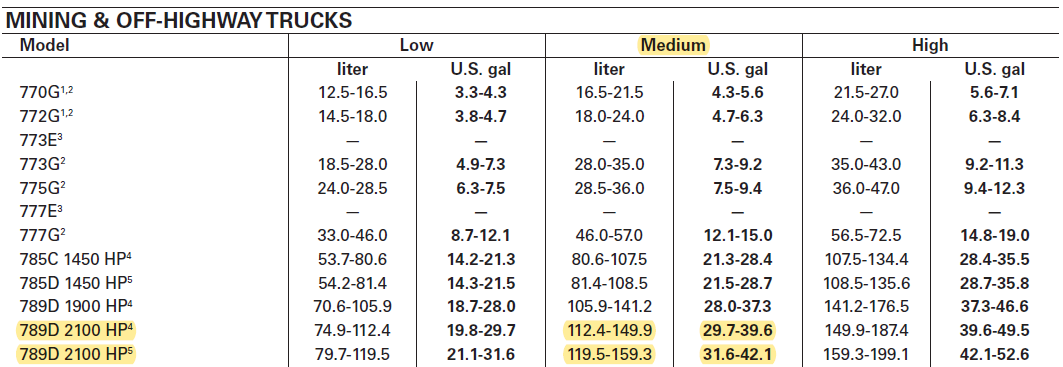

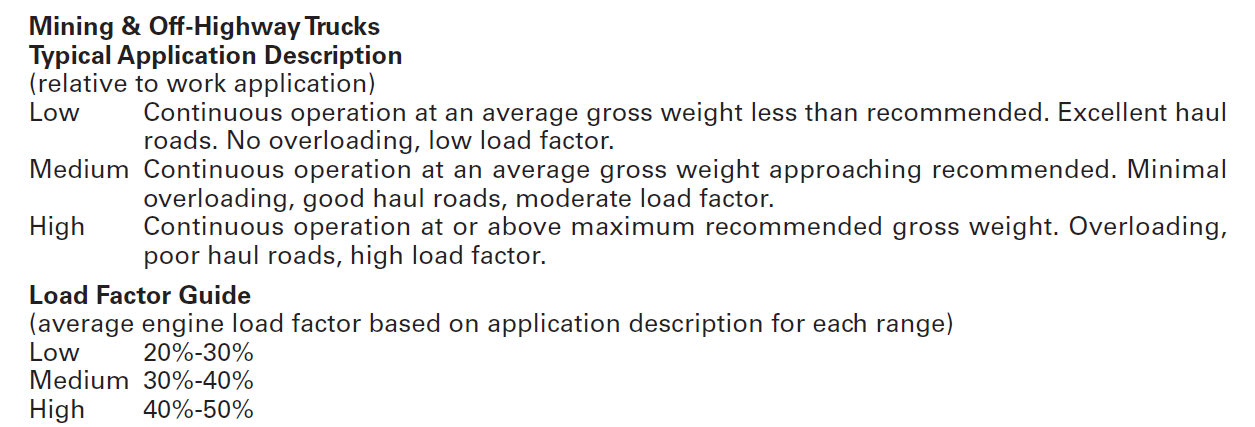


In [32]:
#fuel efficiency = (hrs/year) / (tons/hr * Gal/hr)
ef = eficiency['Tons per hour (Tons/hr)'] * eficiency['Fuel consumed per hour (Gal/hr)']

eficiency['Fuel Eficiency (Tons/Gal)'] = eficiency['Total hours per year (hr/year)'] / ef *100
eficiency

Cycle Time (hh:mm:ss)  Fuel Used (Gal)  \
Equipment Number month                                           
SPD00397         Jan                   25.425           14.045   
                 Feb                   28.292           16.856   
                 Mar                   25.993           13.072   
                 Apr                   20.720            8.175   
                 May                   18.826            9.088   
                 Jun                   19.173            9.223   
                 Jul                   19.414           10.086   
                 Aug                   20.590           10.430   
                 Sep                   23.932            9.347   
                 Oct                   21.300            8.549   
                 Nov                   17.724            7.872   
                 Dec                   20.763            8.067   

                        Fuel consumed per hour (Gal/hr)  \
Equipment Number month                                    
SPD00397         Jan                             32.054   
                 Feb                             34.375   
                 Mar                             28.167   
                 Apr                             24.261   
                 May                             28.464   
                 Jun                             29.275   
                 Jul                             31.541   
                 Aug                             30.203   
                 Sep                             23.400   
                 Oct                             24.199   
                 Nov                             25.794   
                 Dec                             23.265   

                        Cycles per hour (Cycle/hr)  Tons per hour (Tons/hr)  \
Equipment Number month                                                        
SPD00397         Jan                         2.623                  531.314   
                 Feb                         2.343                  464.235   
                 Mar                         2.507                  504.701   
                 Apr                         3.213                  652.811   
                 May                         3.564                  700.181   
                 Jun                         3.442                  677.348   
                 Jul                         3.297                  642.885   
                 Aug                         3.066                  611.514   
                 Sep                         2.640                  526.233   
                 Oct                         2.925                  578.363   
                 Nov                         3.497                  696.876   
                 Dec                         3.023                  631.199   

                        Total hours per year (hr/year)  \
Equipment Number month                                   
SPD00397         Jan                          3045.274   
                 Feb                          3045.274   
                 Mar                          3045.274   
                 Apr                          3045.274   
                 May                          3045.274   
                 Jun                          3045.274   
                 Jul                          3045.274   
                 Aug                          3045.274   
                 Sep                          3045.274   
                 Oct                          3045.274   
                 Nov                          3045.274   
                 Dec                          3045.274   

                        Fuel Eficiency (Tons/Gal)  
Equipment Number month                             
SPD00397         Jan                       17.881  
                 Feb                       19.083  
                 Mar                       21.422  
                 Apr                       19.228  
                 May                    

<AxesSubplot:xlabel='Equipment Number,month'>

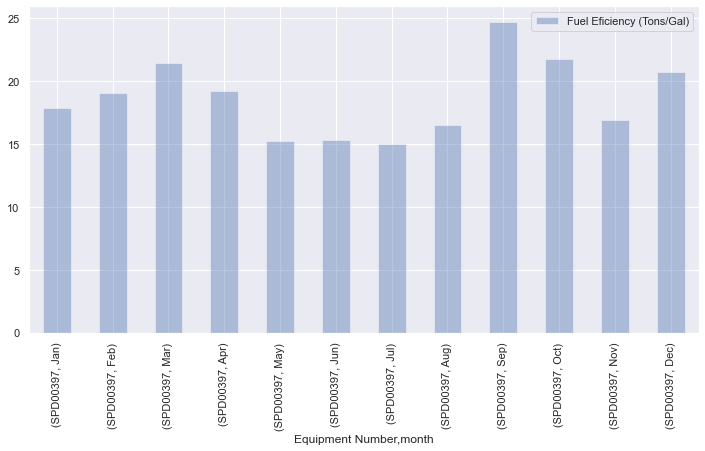

In [33]:
eficiency.plot.bar(y=['Fuel Eficiency (Tons/Gal)'],alpha=0.4, figsize=(12, 6))


● Mechanical Electronic Unit Injection (MEUI™) in the
770 through 793D — Electronically maintains fuel
settings, provides automatic altitude and air filter
restriction compensation, and features automatic
variable timing, improved diagnostics and increased
fuel efficiency.

# Prediction

### Split the data

We'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons.

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.



In [34]:
column_indices = {name: i for i, name in enumerate(df2.columns)}

n = len(df2)
train_df = df2[0:int(n*0.7)]
val_df = df2[int(n*0.7):int(n*0.9)]
test_df = df2[int(n*0.9):]

num_features = df2.shape[1]

NameError: name 'df2' is not defined


It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So in the interest of simplicity this tutorial uses a simple average.



In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
df_std = (df2 - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df2.keys(), rotation=90)

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
w1 = WindowGenerator(input_width=100, label_width=1, shift=100,
                     label_columns=['Payload(Tons)'])
w1

In [ ]:
OUT_STEPS = 168
multi_window = WindowGenerator(input_width=168,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape